In [28]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

from models.unet import Unet

import matplotlib.pyplot as plt
import numpy as np

## Set up

In [29]:
class CFG:
    # dataset
    batch_size = 4
    
    # noise
    B_0 = 1e-4
    B_T = 2e-2
    T = 500
    schedule_type = 'cosine'
    s = 0.008

## Dataset

In [30]:
from torch.utils.data import DataLoader
from data.dataset import CIFAR10_Dataset, MNIST_Dataset

batch_size = CFG.batch_size
train = CIFAR10_Dataset()
train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)

Files already downloaded and verified


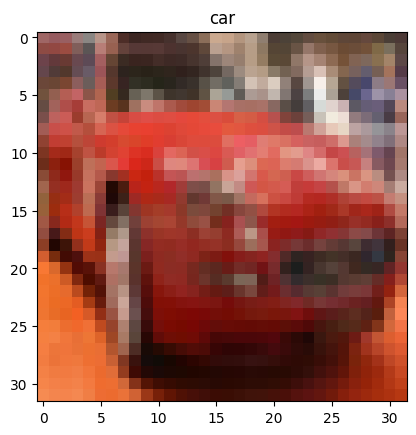

In [31]:
from utils.utils import show_image

image, labels = train[5]
show_image(image, train.classes[labels])

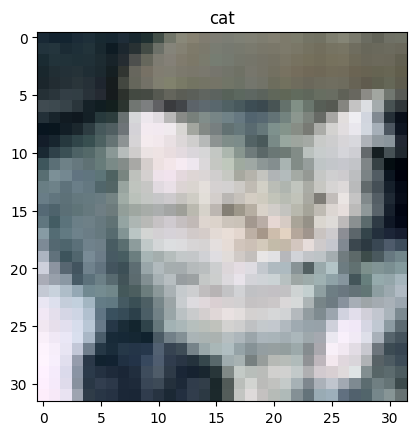

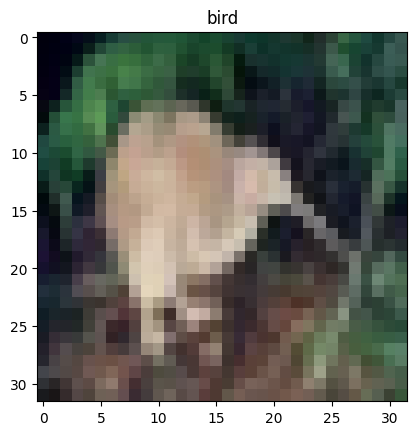

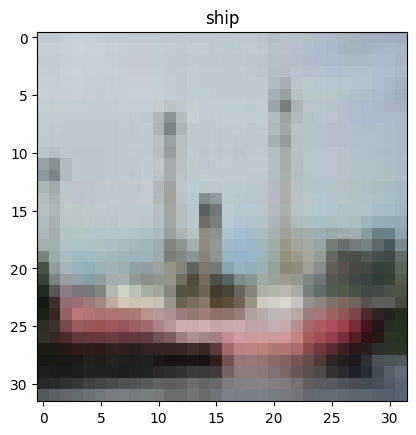

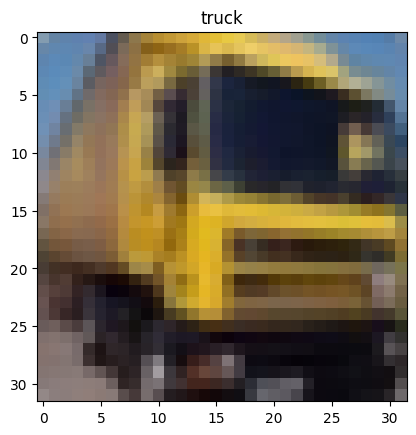

In [32]:
images, labels = next(iter(train_loader))
for image, labels in zip(images, labels):
    show_image(image, train.classes[labels])

## Noise

### Cosine Noise adder

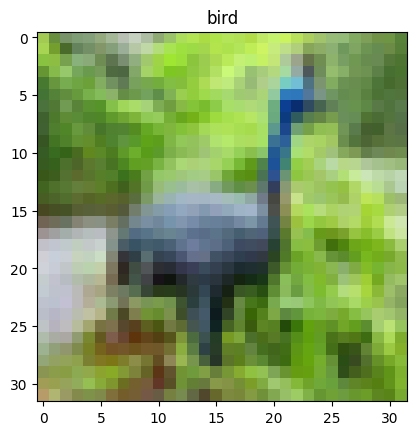

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


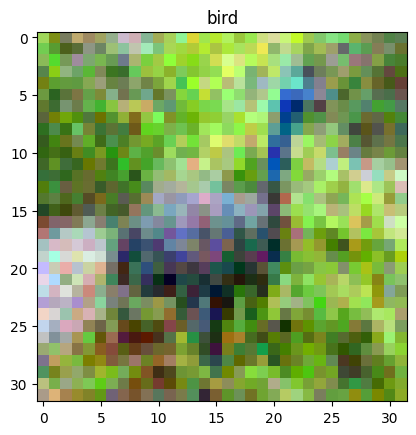

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


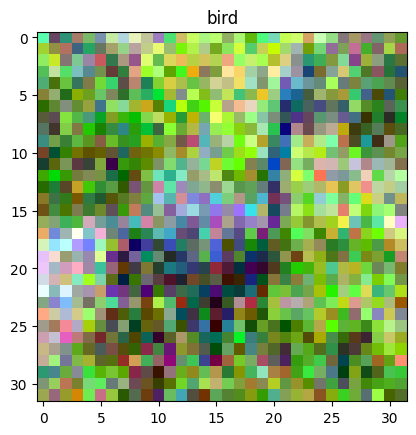

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


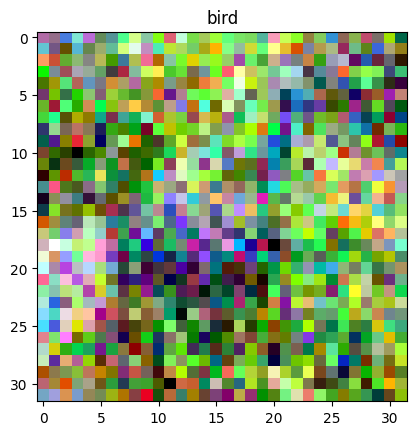

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


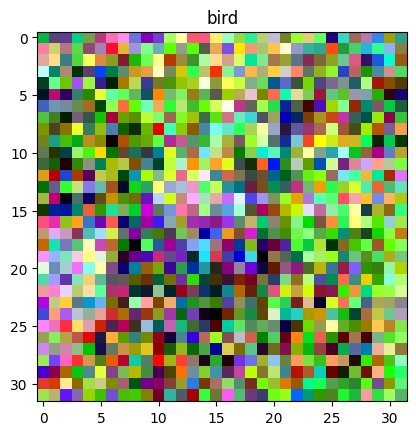

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


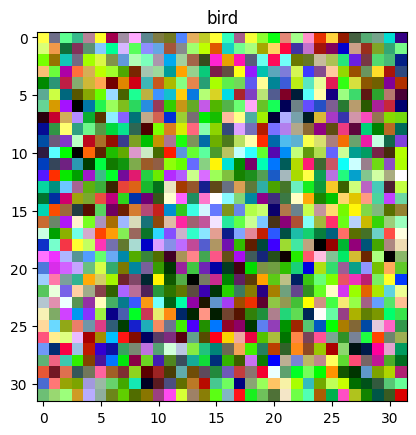

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


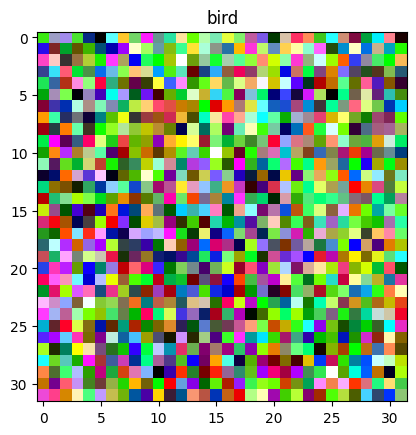

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


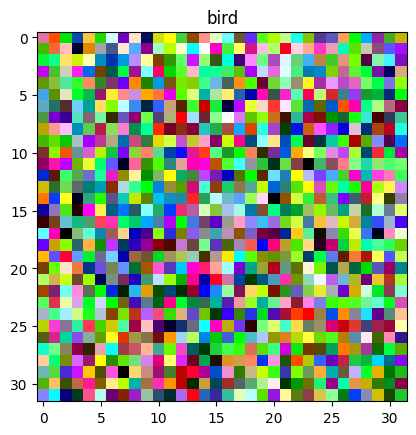

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


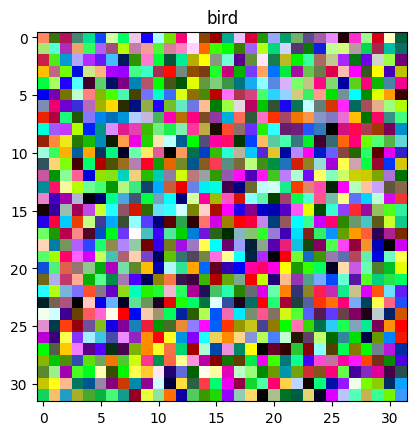

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


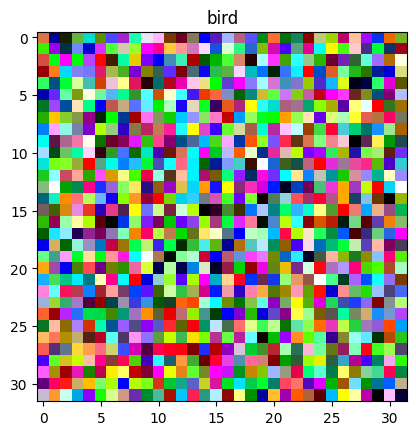

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


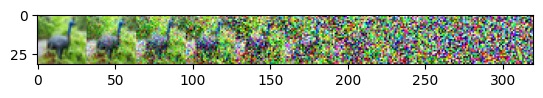

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


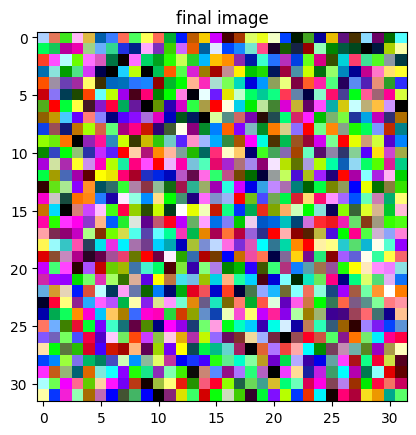

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


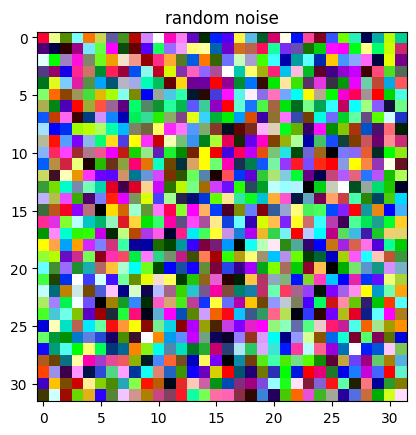

In [33]:
from utils.noise import CosineNoiseAdder

noise_adder = CosineNoiseAdder(CFG.T, CFG.s)

# Example input image
img, labels = train[6]
full_img = torch.tensor([])

# Visualize the noise addition process
for time_steps in torch.arange(0, CFG.T, 50):
    noisy_imgs, noises = noise_adder.image_at_time_step(img, time_steps)
    full_img = torch.cat((full_img, noisy_imgs), 2)
    show_image(noisy_imgs, train.classes[labels])
show_image(full_img)

final_noisy_img, noises = noise_adder.image_at_time_step(img, CFG.T - 1)
show_image(final_noisy_img, title="final image")

final_noise = torch.randn_like(img)
show_image(final_noise, title="random noise")

## Unet Model

In [34]:
train = CIFAR10_Dataset()
train_loader = DataLoader(train, shuffle=True, batch_size=16)
batch = next(iter(train_loader))
print(batch[0].shape)
# img, label = train[6]
imgs = batch[0]

# fake data for testing
# imgs = torch.randn(16, 3, 128, 128)

Files already downloaded and verified
torch.Size([16, 3, 32, 32])


## Noise Dataset

In [35]:
class NoiseDataset():
    def __init__(self, imgs_dataset, noise_schedule = None):
        self.imgs_dataset = imgs_dataset
        self.noise_schedule = noise_schedule if noise_schedule else CosineNoiseAdder()       

    def __getitem__(self, idx):
        img, label = self.imgs_dataset[idx]
        t = torch.randint(self.noise_schedule.T, (1, )).squeeze()
        # print(t)
        # t = 30
        noisy_img, noise = self.noise_schedule.image_at_time_step(img, t)
        return noisy_img, noise, t, label

    def __len__(self):
        return len(self.imgs_dataset)

## Training

torch.Size([16, 1, 28, 28]) torch.Size([16, 1, 28, 28]) torch.Size([16]) torch.Size([16])

 torch.Size([16, 1, 28, 28])


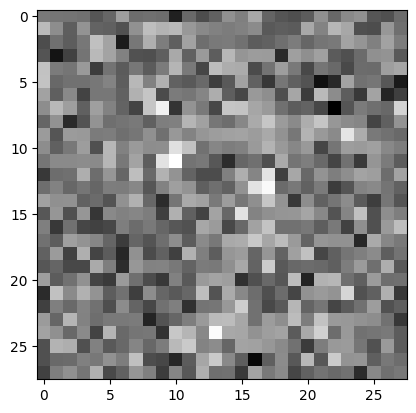

In [36]:
max_time_steps = 100
batch_size = 16

CosineNoise = CosineNoiseAdder(max_time_steps)

train = NoiseDataset(MNIST_Dataset(), CosineNoise)
test = NoiseDataset(MNIST_Dataset('test'), CosineNoise)

# train = NoiseDataset(CIFAR10_Dataset(), CosineNoise)
# test = NoiseDataset(CIFAR10_Dataset('test'), CosineNoise)

train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test, shuffle=False, batch_size=batch_size)

net = Unet(16, 2, 8, initial_channels=1, conv_layers=1)


noisy_imgs, noises, time_steps, labels = next(iter(train_loader))
print(noisy_imgs.shape, noises.shape, time_steps.shape, labels.shape)
# noisy_imgs, noises = torchvision.transforms.Resize((32, 32))(noisy_imgs), torchvision.transforms.Resize((32, 32))(noises)
print("\n", net(noisy_imgs, time_steps).shape)
show_image(noisy_imgs[0])

### Weight Initialization

In [37]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


### Eval

In [38]:
def eval_model(model:nn.Module, criterion, device):
    model.eval()
    with torch.no_grad():
        for i, (noisy_imgs, noises, time_steps, labels) in enumerate(test_loader):
            noisy_imgs, noises, time_steps = noisy_imgs.to(device), noises.to(device), time_steps.to(device)
            outputs = model(noisy_imgs, time_steps)
            loss = criterion(outputs, noises)
            # print(f"Batch {i}, Loss: {loss.item()}")
            return loss.item()

### Training Loop

In [ ]:
# hyperparameters
n_epochs = 10
batch_size = 16
lr = 1e-2
max_time_steps = 100
eval_every = 100

# model creation
net = Unet(16, 2, 8, initial_channels=1, conv_layers=2)
net.apply(init_weights)

# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1,  gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs * len(train_loader), eta_min=1e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, min_lr=1e-4)

# dataset creation
train = NoiseDataset(MNIST_Dataset(), CosineNoise)
test = NoiseDataset(MNIST_Dataset('test'), CosineNoise)
train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test, shuffle=False, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
net.to(device)

# keep track of the loss
train_losses = []
val_losses = []
best_loss = np.inf
best_loss_i = 0
# training loop
for epoch in range(n_epochs):
    for i, batch in enumerate(train_loader):
        noisy_imgs, noises, time_steps, labels = batch
        noisy_imgs, noises, time_steps, labels = noisy_imgs.to(device), noises.to(device), time_steps.to(device), labels.to(device)
        # print(noisy_imgs.shape, noises.shape, time_steps.shape, labels.shape)
        
        optimizer.zero_grad()
        
        predicted_noise = net(noisy_imgs, time_steps)
        loss = criterion(predicted_noise, noises)
        
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_loss_i = epoch * len(train_loader) + i
            torch.save(net.state_dict(), 'best_model_MNIST.pth')
        train_losses.append(loss.item())
        
        # if epoch * len(train_loader) + i - best_loss_i > 1000:
        #     print("Stopping early")
        #     break
        
        if i%eval_every == 0:
            val_loss = eval_model(net, criterion, device)
            val_losses.append(val_loss)
            # scheduler.step(val_loss)
            print(f'Epoch [{epoch+1}/{n_epochs}], step({i}/{len(train_loader)}), Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, lr: {scheduler.get_last_lr()[0]}')
            # print(f'Epoch [{epoch+1}/{n_epochs}], step({i}/{len(train_loader)}), Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

        
        
        # show_image(noisy_imgs[0], title="noisy image")
        # show_image(predicted_noise[0], title="predicted noise")
        
        # break
    if epoch < 5:
        scheduler.step()
    # break
    
plt.plot(val_losses)


Using device: cuda
Epoch [1/10], step(0/3750), Loss: 1.3255, Val Loss: 0.9258, lr: 0.01
Epoch [1/10], step(100/3750), Loss: 0.2550, Val Loss: 0.2769, lr: 0.01
Epoch [1/10], step(200/3750), Loss: 0.2896, Val Loss: 0.2511, lr: 0.01
Epoch [1/10], step(300/3750), Loss: 0.2441, Val Loss: 0.2230, lr: 0.01
Epoch [1/10], step(400/3750), Loss: 0.2280, Val Loss: 0.2189, lr: 0.01
Epoch [1/10], step(500/3750), Loss: 0.2379, Val Loss: 0.1978, lr: 0.01
Epoch [1/10], step(600/3750), Loss: 0.2447, Val Loss: 0.2397, lr: 0.01
Epoch [1/10], step(700/3750), Loss: 0.2189, Val Loss: 0.2319, lr: 0.01
Epoch [1/10], step(800/3750), Loss: 0.2073, Val Loss: 0.2376, lr: 0.01
Epoch [1/10], step(900/3750), Loss: 0.2443, Val Loss: 0.2738, lr: 0.01
Epoch [1/10], step(1000/3750), Loss: 0.2063, Val Loss: 0.2379, lr: 0.01
Epoch [1/10], step(1100/3750), Loss: 0.1968, Val Loss: 0.2202, lr: 0.01
Epoch [1/10], step(1200/3750), Loss: 0.2273, Val Loss: 0.2193, lr: 0.01
Epoch [1/10], step(1300/3750), Loss: 0.2181, Val Loss: 0.

## Sampling

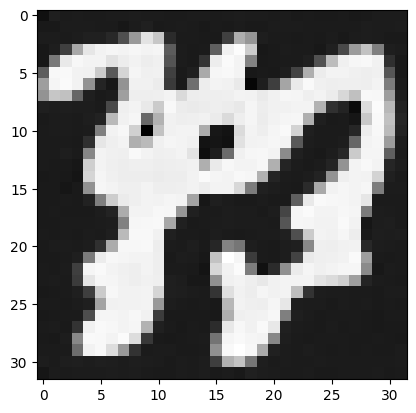

In [ ]:
max_time_steps = 100

n_samples = 1
xt = torch.randn((n_samples, 1, 32, 32)).to(device)
T = max_time_steps
s = 0.008

# print(CosineNoise.get_alpha_t(T))

with torch.no_grad():
    for t in torch.arange(max_time_steps, 0, -1):
        t = t.expand((n_samples)).to(device)
        a_t = CosineNoise.get_alpha_t(t)
        alpha_t_barre = CosineNoise.get_alpha_t_barre(t)
        sigma = torch.sqrt(1-a_t).view(n_samples, 1, 1, 1)
        z = torch.randn_like(xt)
        # print(xt.shape)
        epsilon = net(xt, t)
        a = ((1 - a_t)/(torch.sqrt(1 - alpha_t_barre))).view(n_samples, 1, 1, 1)
        b = (1/torch.sqrt(a_t)).view(n_samples, 1, 1, 1)
        # print(t[0].item(), a_t[0].item(), alpha_t_barre[0].item(), sigma[0].item(), a[0].item(), b[0].item(), z.shape, epsilon.shape, sep=' | ')
        # print(xt.shape, epsilon.shape)
        
        # xt = b*(xt - a*epsilon) + sigma*z

        # xt = torch.sqrt(1- a_t).view(n_samples, 1, 1, 1) * epsilon + sigma * z
        
        xt = b * (xt - torch.sqrt(1-alpha_t_barre)*epsilon) + sigma*z
        
        # print(xt[0][0][0][0], xt[0][1][0][0], xt[0][2][0][0])
        # print(xt[0])
    show_image(xt[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


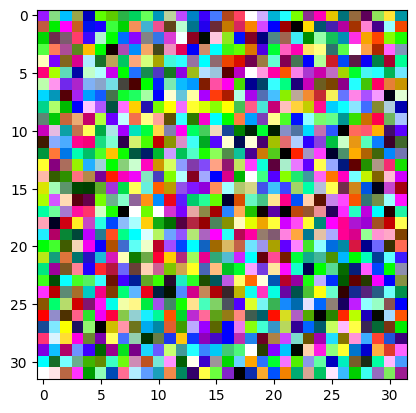

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


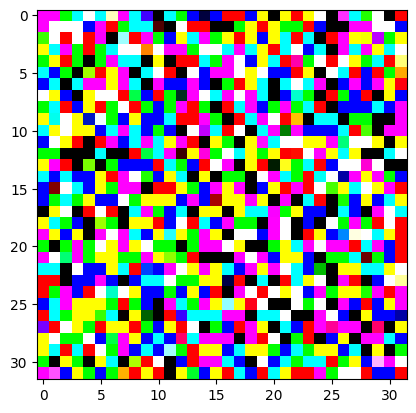

In [ ]:
x = torch.randn((3, 32, 32))
show_image(x)

for _ in range(1000):
    x += torch.randn_like(x)

show_image(x)
